In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.impute import SimpleImputer

In [3]:
data= pd.read_csv("training_data.csv", sep=";", decimal=',')
data.head()

FileNotFoundError: [Errno 2] No such file or directory: 'training_data.csv'

In [ ]:
data.dtypes
data.shape

(8000, 119)

In [ ]:
#is the dataset balanced?
data['Class'].value_counts()

Class
 1    3768
-1    3096
 0    1136
Name: count, dtype: int64

/var/folders/s2/0n9llbr92yqd6tcq33z2gx8m0000gn/T/ipykernel_1854/3257580549.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(data['Perform'])


<Axes: xlabel='Perform', ylabel='Density'>

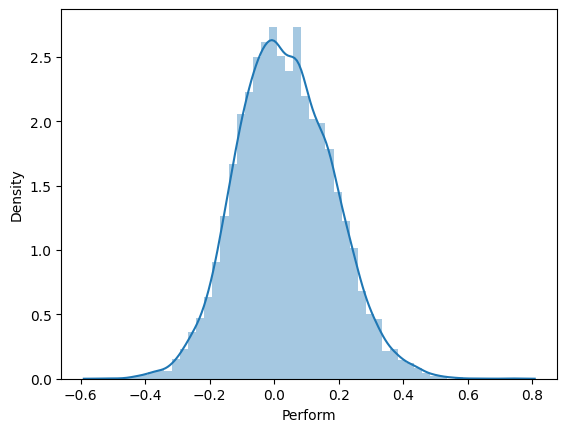

In [ ]:
sb.distplot(data['Perform'])

In [ ]:
#missing values
data=data.replace(r'\s+$', np.nan, regex=True)
total= data.isnull().sum().sort_values(ascending=False)
percent=(data.isnull().sum()/len(data)).sort_values(ascending=True)
missing=pd.concat([total,percent], axis=1, keys=['total','percent'])
missing.head(20)
#data.isnull().sum().sum()
#no need to remove any column

,total,percent
dI21,1564,0.195500
dI48,1553,0.194125
dI50,1553,0.194125
I21,1553,0.194125
I48,1540,0.192500
I50,1540,0.192500
dI24,757,0.094625
I24,730,0.091250
dI14,682,0.085250
I14,675,0.084375


In [ ]:
#imputing missing value and creating a dummy column associated with that
cols_with_missing= [col for col in data.columns if data[col].isnull().any()]


#dummy column indicating missing values
datacopy= data.copy()
for col in cols_with_missing:
    datacopy[col + '_missing']= datacopy[col].isnull().astype(int)
    
datacopy.head()

features=datacopy.drop('Class', axis=1)
target=datacopy['Class']

features['I4_missing']

0       0
1       0
2       0
3       0
4       0
       ..
7995    1
7996    0
7997    0
7998    0
7999    0
Name: I4_missing, Length: 8000, dtype: int64

In [ ]:
#train and test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.33, random_state=42)

X_train.index


Index([1194, 7600, 2885, 1756,  497, 2868, 7818,  912,  721, 5828,
       ...
       6265, 5734, 3092, 3772, 5191, 5226, 5390,  860, 7603, 7270],
      dtype='int64', length=5360)

In [ ]:
#imputing numerical columns

numerics=X_train.drop('Group', axis=1)
imputer= SimpleImputer()
#imputation
numeric_imp = pd.DataFrame(imputer.fit_transform(numerics))

#imputation removes columns names, put it back
numeric_imp.columns=numerics.columns
numeric_imp.head(10)

#applying to test set

numerics_test=X_test.drop('Group', axis=1)

#imputation
numeric_test_imp = pd.DataFrame(imputer.transform(numerics_test))

#imputation removes columns names, put it back
numeric_test_imp.columns=numerics_test.columns



In [ ]:
#encoding the categorical variable Group
categorical=X_train['Group']

from sklearn.preprocessing import OneHotEncoder
encoder= OneHotEncoder(handle_unknown='ignore', drop='first')
categorical_imp=encoder.fit_transform(categorical.values.reshape(-1,1)).toarray()
one_hot_df = pd.DataFrame(categorical_imp, columns = encoder.get_feature_names_out(['Industry']))

#applying to test data

categorical_test=X_test['Group']
categorical_test_imp=encoder.transform(categorical_test.values.reshape(-1,1)).toarray()
one_hot_test=pd.DataFrame(categorical_test_imp, columns = encoder.get_feature_names_out(['Industry']))




In [ ]:
#scaling numerical variables

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

#we dont want to scale dummy variables
numerical_cols = [col for col in numeric_imp.columns if numeric_imp[col].nunique() > 2]

numerical_cols_test = [col for col in numeric_test_imp.columns if numeric_test_imp[col].nunique() > 2]
#scaling train data
scaled_numeric= pd.DataFrame(scaler.fit_transform(numeric_imp[numerical_cols]), columns=numerical_cols, index=numeric_imp.index)
#scaling test data
scaled_numeric_test= pd.DataFrame(scaler.transform(numeric_test_imp[numerical_cols_test]), columns=numerical_cols_test, index=numeric_test_imp.index)

#combining scaled data set with dummy variables for missing values and one hot encoding for Group
train_features= pd.concat([scaled_numeric, numeric_imp.drop(columns=numerical_cols), one_hot_df], axis=1)

test_features= pd.concat([scaled_numeric_test, numeric_test_imp.drop(columns=numerical_cols_test), one_hot_test], axis=1)

train_features['I1']


0      -1.112541
1      -0.450843
2      -0.664150
3       0.153965
4       0.262270
          ...   
5355   -0.613184
5356   -0.407603
5357    0.454242
5358   -0.777811
5359   -0.086117
Name: I1, Length: 5360, dtype: float64

In [ ]:
#joinning train data as well as test data
train_features=pd.concat([numeric_imp, one_hot_df],axis=1)
test_features=pd.concat([numeric_test_imp, one_hot_test],axis=1)
train_features.head()

,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,...,Industry_G10,Industry_G11,Industry_G2,Industry_G3,Industry_G4,Industry_G5,Industry_G6,Industry_G7,Industry_G8,Industry_G9
0,-0.937674,-0.043174,-0.060529,-1.038730,-0.119581,-0.211232,-0.459784,-0.067414,-1.532220,-0.044020,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.339604,-0.003061,-0.019806,0.571112,-0.002608,0.116650,-0.028551,-0.017707,-0.774352,-0.014221,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.532400,-0.040596,-0.051056,-0.377839,-0.249689,-0.234167,-0.475414,-0.066907,-1.175289,-0.030765,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.207048,-0.030008,-0.042828,-0.264777,-0.160181,-0.365308,-0.563611,-0.059762,-0.664492,-0.017522,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.304939,-0.023269,-0.034556,-0.290166,-0.211908,0.257417,0.134753,-0.038507,0.348360,-0.026316,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
#scaling and standardization
train_features.dtypes

I1             float64
I2             float64
I3             float64
I4             float64
I5             float64
                ...   
Industry_G5    float64
Industry_G6    float64
Industry_G7    float64
Industry_G8    float64
Industry_G9    float64
Length: 202, dtype: object

In [ ]:
#first n rows with the largest values in column performance
corr_matrix= train_features.corr()
corr_matrix['Perform'].abs().nlargest(n=5)

Perform    1.000000
I9         0.081429
dI9        0.073350
dI6        0.065542
I45        0.062357
Name: Perform, dtype: float64

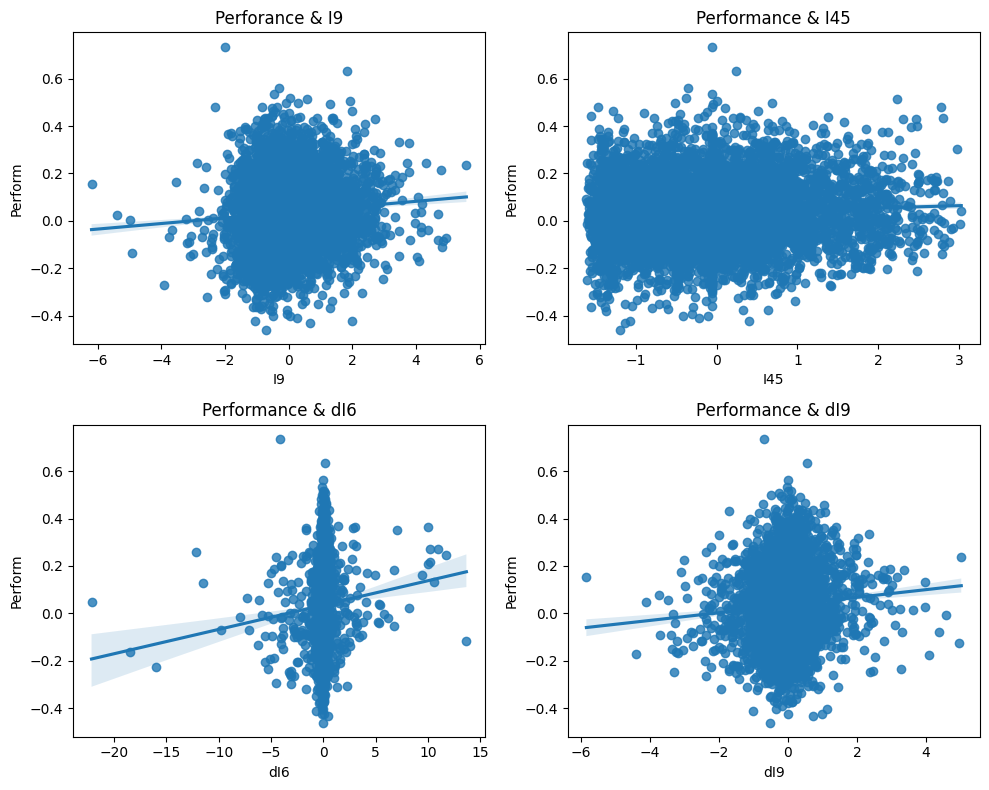

In [ ]:
#plot for assesing the effect of numerical variables on performance 

fig,axs= plt.subplots(2,2, figsize=(10,8))
sb.regplot(x= 'I9',y= 'Perform', data= train_features, ax=axs[0,0])
axs[0,0].set_title('Perforance & I9')

sb.regplot(x='I45', y='Perform', data=train_features, ax=axs[0,1])
axs[0,1].set_title('Performance & I45')

sb.regplot(x='dI6', y='Perform', data=train_features, ax=axs[1,0])
axs[1,0].set_title('Performance & dI6')


sb.regplot(x='dI9', y='Perform', data=train_features, ax=axs[1,1])
axs[1,1].set_title('Performance & dI9')


plt.tight_layout()
plt.show()

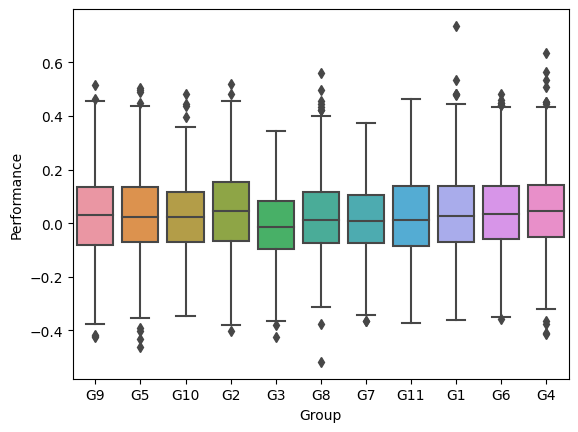

In [ ]:
#assesing the effect of Group on performance

sb.boxplot(x='Group', y='Perform', data=data)
plt.xlabel('Group')
plt.ylabel('Performance')
plt.show()

In [ ]:

#corr_matrix for features

numerical_cols = [col for col in train_features.columns if train_features[col].nunique() > 2]
pairs= train_features[numerical_cols].corr().abs().unstack().sort_values(ascending=False)
unique_pairs = []

# Iterate over the pairs and add only unique pairs to the list
for pair in pairs.index:
    if pair[0] != pair[1] and (pair[1], pair[0]) not in unique_pairs:
        unique_pairs.append(pair)
unique_pairs

top_pairs_df = pd.DataFrame(columns=['feature_1', 'feature_2', 'corr_coef'])
for i, pair in enumerate(unique_pairs):
    top_pairs_df.loc[i] = [pair[0], pair[1], corr_matrix.loc[pair[0], pair[1]]]

# Print the top pairs as a dataframe
top_pairs_df.head(20)


,feature_1,feature_2,corr_coef
0,dI33,dI34,1.000000
1,I33,I34,1.000000
2,dI8,dI3,0.995226
3,I3,I2,0.990272
4,dI10,dI2,0.988285
5,I8,I3,0.985560
6,dI6,dI7,0.982150
7,I8,I2,0.981454
8,dI3,dI2,0.977685
9,dI2,dI8,0.973808


In [ ]:
#using polynomial features and then check correlation to perform
from sklearn.preprocessing import PolynomialFeatures

#relevent data is the one with numerical features
numerical_cols = [col for col in train_features.columns if train_features[col].nunique() > 2]
relvdata= train_features[numerical_cols]
performance=train_features['Perform']

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly= poly.fit_transform(relvdata.drop(['Perform'] , axis=1))
poly_df= pd.DataFrame(X_poly, columns= poly.get_feature_names_out())

#correlation with perform
corr_with_perform= poly_df.corrwith(performance).nlargest(5)
corr_with_perform



I9     0.081429
dI9    0.073350
dI6    0.065542
I45    0.062357
dI7    0.059703
dtype: float64

In [ ]:
#checking interaction between features and correlation 

pol = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
X_pol= pol.fit_transform(relvdata.drop(['Perform'] , axis=1))
pol_df= pd.DataFrame(X_pol, columns= pol.get_feature_names_out())

#correlation with perform
corr_with_perform= pol_df.corrwith(performance).nlargest(5)
corr_with_perform

I9            0.081429
dI9           0.073350
I2 I22 dI6    0.071683
I1 I6 dI37    0.070538
I1 I6 dI36    0.070531
dtype: float64

In [ ]:
#using summary statistics

summary_statistics = pd.DataFrame()
summary_statistics['Mean'] = relvdata.mean(axis=1)
summary_statistics['Median'] = relvdata.median(axis=1)
correlation_with_target_aggregation = summary_statistics.apply(lambda x: x.corr(performance))
correlation_with_target_aggregation

Mean      0.062957
Median    0.099392
dtype: float64

In [ ]:
#power transforming
from sklearn.preprocessing import PowerTransformer
pt=PowerTransformer()
X_pt= pt.fit_transform(relvdata.drop(['Perform'], axis=1))
pt_df=pd.DataFrame(X_pt, columns=pt.get_feature_names_out())
corr_with_perform= pt_df.corrwith(performance).nlargest(5)
corr_with_perform

I9     0.086295
dI9    0.073453
I4     0.073143
I8     0.070054
dI6    0.066532
dtype: float64

We also tried to go the route of domain knowledge typical recommendations for stock picking as a classification task were to use things related to: 
- Earnings Per Share
- Price to Earnings Ratio
- Return on Equity 
- Debt to Equity Ratio
- Market Capitalization 

In [ ]:
domain_knowledge = []

search_terms =["price","growth", "PE", "EPS" "Return", "Equity", "Debt", "market"
]

for term in search_terms:
    domain_knowledge = domain_knowledge + colnames[colnames.loc[:,"INDICATOR NAME"].str.contains(
term,
regex = True, case = False
)]["CODE"].tolist()
    domain_knowledge =domain_knowledge + ['Class', "Perform"]


In [ ]:
dk_data =data.filter(items=domain_knowledge)
dk_data.head()

In [ ]:
dk_data.drop(['Class'], axis=1).corr()['Perform'].abs().nlargest(n=10)

In [ ]:
corr_matrix['Perform'].abs().nlargest(n=10)